# Sentinel-3 OLCI Land

* **Products used:** 
[s3_olci_l2_lfr](https://explorer.digitalearth.africa/products/s3_olci_l2_lfr)

## Background

The Sentinel-3 OLCI Level-2 Land Full Resolution (OL_2_LFR) product provides atmospherically corrected observations and biophysical parameters derived from the Ocean and Land Colour Instrument (OLCI) onboard Sentinel-3A and 3B satellites. The product delivers consistent measurements of vegetation condition and atmospheric properties at **300 m resolution**, making it valuable for a wide range of environmental and agricultural applications, including:

* Vegetation health and stress monitoring
* Drought early warning and food security assessments
* Land surface process and ecosystem modelling
* Crop condition analysis and agricultural productivity studies
* Phenology and seasonal dynamics monitoring
* Climate and atmospheric studies (via integrated water vapour)
* Long-term land cover and change mapping

The algorithms and retrieval approaches have been developed by the European Space Agency (ESA) and partners, ensuring continuity with MERIS heritage and improved spectral and radiometric performance. Validation draws on ground-based measurements and inter-comparison with other satellite products. More information on the product can be found in the OLCI Land User Guide and Algorithm Theoretical Basis Documents [ATBDs](https://sentiwiki.copernicus.eu/web/s3-documents).
***

## Description

This notebook will cover following topics:

1. Inspecting the products and measurements available in the datacube
2. Loading Sentinel 3 Sentinel-3 OLCI Data.
3. Plotting the results

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import geopandas as gpd
from odc.geo.geom import Geometry

from deafrica_tools.plotting import display_map
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app="Sentinel_3")

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
dc.list_products().loc[dc.list_products()['description'].str.contains('Sentinel-3')]

,name,description,license,default_crs,default_resolution
name,,,,,
s3_ol_2_wfr_nrt,s3_ol_2_wfr_nrt,Sentinel-3 Level 2 Water Full Resolution (WFR)...,CC-BY-4.0,EPSG:4326,"(-0.003, 0.003)"
s3_olci_l2_lfr,s3_olci_l2_lfr,Sentinel-3 OLCI L2 LAND,CC-BY-4.0,EPSG:4326,"(-0.003, 0.003)"


Please choose the product by specifying its name, with the product `s3_olci_l2_lfr`

In [4]:
product = "s3_olci_l2_lfr"

### List measurements

We can further inspect the data available for each `s3_olci_l2_lfr` product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [5]:
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition,add_offset,scale_factor
measurement,,,,,,,,
GIFAPAR,GIFAPAR,uint16,1,65535,[GI-FAPAR],NaN,0.0,10000.0
IWV_L,IWV_L,uint8,kg/m²,255,[water_vapour],NaN,0.0,1.0
OTCI,OTCI,uint16,1,65535,[chlorophyll],NaN,0.0,10000.0
RC681,RC681,uint16,1,65535,NaN,NaN,0.0,10000.0
RC865,RC865,uint16,1,65535,NaN,NaN,0.0,10000.0
LQSF,LQSF,float32,1,-1,NaN,NaN,0.0,1.0
dataMask,dataMask,uint8,1,255,[mask],NaN,0.0,1.0


The Sentinel-3 product has seven measurements:

| Measurement                                   | Description                                                                                                                             | Application                                                                                      |
| --------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------ |
| **GIFAPAR** (Green Instantaneous FAPAR)       | Fraction of Absorbed Photosynthetically Active Radiation (green component) at observation time. Indicates photosynthetic energy uptake. | Vegetation productivity monitoring, drought early warning, crop and forest condition assessment. |
| **IWV\_L** (Integrated Water Vapour – Land)   | Column-integrated water vapour content above each pixel.                                                                                | Climate modelling, evapotranspiration studies, vegetation stress analysis.                       |
| **OTCI** (OLCI Terrestrial Chlorophyll Index) | Index sensitive to canopy chlorophyll content derived from OLCI spectral bands.                                                         | Crop stress detection, canopy functioning studies, biomass dynamics monitoring.                  |
| **RC681** (Rectified Reflectance 681 nm)      | Atmospherically corrected surface reflectance in the red band (681 nm).                                                                 | Input for vegetation indices and biophysical parameter retrievals.                               |
| **RC865** (Rectified Reflectance 865 nm)      | Atmospherically corrected surface reflectance in the NIR band (865 nm).                                                                 | Used with RC681 for GIFAPAR; vegetation monitoring and photosynthetic activity modelling.        |
| **LQSF** (Land Quality & Science Flags)       | Per-pixel quality and classification information (land/water/cloud/snow).                                                               | Masking invalid pixels, cloud/snow filtering, ensuring robust time-series analysis.              |
| **dataMask**                                  | Binary mask indicating valid vs. invalid observations.                                                                                  | Excluding missing/invalid values, ensuring reliable data analysis.                               |

***

### Analysis parameters

The following cell sets the parameters, which define the area of interest to conduct the analysis over.
#### Select location
To define the area of interest, there are two methods available:

1. By specifying the latitude, longitude, and buffer, or separate latitude and longitude buffers, this method allows you to define an area of interest around a central point. You can input the central latitude, central longitude, and a buffer value in degrees to create a square area around the center point. For example, `lat = 10.338`, `lon = -1.055`, and `buffer = 0.1` will select an area with a radius of 0.1 square degrees around the point with coordinates `(10.338, -1.055)`. 
    
    Alternatively, you can provide separate buffer values for latitude and longitude for a rectangular area. For example, `lat = 10.338`, `lon = -1.055`, and `lat_buffer = 0.1` and`lon_buffer = 0.08` will select a rectangular area extending 0.1 degrees north and south, and 0.08 degrees east and west from the point `(10.338, -1.055)`.

   For reasonable loading times, set the buffer as `0.1` or lower.

3. By uploading a polygon as a `GeoJSON or Esri Shapefile`. If you choose this option, you will need to upload the geojson or ESRI shapefile into the Sandbox using Upload Files button <img align="top" src="../Supplementary_data/upload_files_icon.png"> in the top left corner of the Jupyter Notebook interface. ESRI shapefiles must be uploaded with all the related files `(.cpg, .dbf, .shp, .shx)`. Once uploaded, you can use the shapefile or geojson to define the area of interest. Remember to update the code to call the file you have uploaded.

To use one of these methods, you can uncomment the relevant line of code and comment out the other one. To comment out a line, add the `"#"` symbol before the code you want to comment out. By default, the first option which defines the location using latitude, longitude, and buffer is being used.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers a central Congo Basin belt (evergreen lowland rainforest) in Democratic Republic of the Congo (DRC), northeastern part of the country—within Tshopo Province.

**To run the notebook for a different area**, make sure Sentinel-3 OLCI Land data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).

In [6]:
# Method 1: Specify the latitude, longitude, and buffer)
aoi = define_area(lat=1.066, lon=26.455, buffer=0.9)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
# aoi = define_area(vector_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

In [7]:
display_map(x=lon_range, y=lat_range)

## Load Sentinel-3 dataset using `dc.load()`

Now that we know what products and measurements are available for the product, we can load data from the datacube using `dc.load`. We will load data from spectral satellite bands. By specifying output_crs='EPSG:4326' and resolution=(-0.003, -0.003), we request that datacube reproject our data to the global geographic coordinate reference system (CRS), with 300 x 300 m pixels. Finally, group_by='solar_day' ensures that overlapping images taken within seconds of each other as the satellite passes over are combined into a single time step in the data.

In [8]:
query = {
    'x': (lon_range),
    'y': (lat_range),
    'time':('2025-04-01', '2025-04-30'),
    'output_crs': 'EPSG:4326',
    'resolution': (-0.003, 0.003)}

ds_S3 = dc.load(product=product,
                group_by="solar_day",
                **query)

ds_S3

<xarray.Dataset> Size: 152MB
Dimensions:      (time: 30, latitude: 601, longitude: 601)
Coordinates:
  * time         (time) datetime64[ns] 240B 2025-04-01T04:00:49 ... 2025-04-3...
  * latitude     (latitude) float64 5kB 1.966 1.964 1.96 ... 0.1695 0.1665
  * longitude    (longitude) float64 5kB 25.56 25.56 25.56 ... 27.35 27.35 27.36
    spatial_ref  int32 4B 4326
Data variables:
    GIFAPAR      (time, latitude, longitude) uint16 22MB 0 6732 6969 ... 0 0 0
    IWV_L        (time, latitude, longitude) uint8 11MB 0 44 43 43 ... 0 0 0 0
    OTCI         (time, latitude, longitude) uint16 22MB 0 24311 24823 ... 0 0 0
    RC681        (time, latitude, longitude) uint16 22MB 0 383 372 376 ... 0 0 0
    RC865        (time, latitude, longitude) uint16 22MB 0 3549 3667 ... 0 0 0
    LQSF         (time, latitude, longitude) float32 43MB 8.0 1.678e+07 ... 8.0
    dataMask     (time, latitude, longitude) uint8 11MB 0 1 1 1 1 ... 1 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

>Note:  When using the dc.load function, some Sentinel-3 OLCI Land bands are stored as integers with a scale factor **(e.g., 0.0001) or offset (e.g., 1000)** applied, depending on the CRS. This scaling is used to efficiently store values in integer format. To obtain the correct surface values, the scale or offset must be reversed. The example below demonstrates how to apply this correction.

#### Visualise Sentinel-3 Land `GIFAPAR` band
The cell below visualizes the Fraction of Absorbed Photosynthetically Active Radiation (green component) at the time of observation, which represents photosynthetic energy uptake. Values range from 0 to 1.

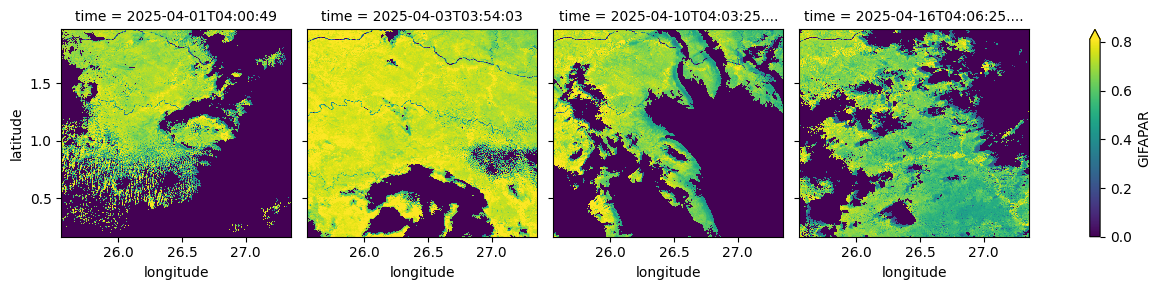

In [9]:
(ds_S3.isel(time=[0, 2, 9, 15])['GIFAPAR']*0.0001).plot(robust=True, col="time", col_wrap=4);

#### Visualise Sentinel-3 Land `OTCI` band
The cell below visualizes the OLCI Terrestrial Chlorophyll Index (OTCI), an index sensitive to canopy chlorophyll content derived from OLCI spectral bands. It provides information on vegetation health and photosynthetic activit

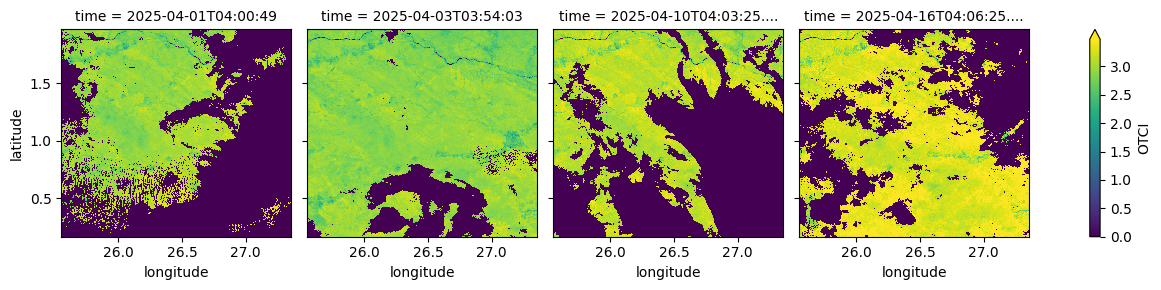

In [10]:
(ds_S3.isel(time=[0, 2, 9, 15])['OTCI']*0.0001).plot(robust=True, col="time", col_wrap=4)

#### Visualise Sentinel-3 Land `RC681` band
The cell below visualizes the atmospherically corrected surface reflectance in the red band (681 nm). This measurement is used in vegetation indices and biophysical parameter retrievals,

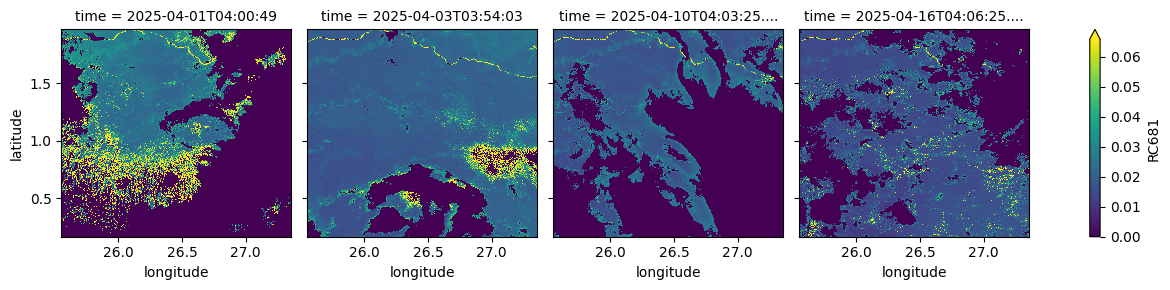

In [11]:
(ds_S3.isel(time=[0, 2, 9, 15])['RC681']*0.0001).plot(robust=True, col="time", col_wrap=4)

#### Visualise Sentinel-3 Land `RC865` band
The cell below visualizes the atmospherically corrected surface reflectance in the near-infrared band (865 nm). This measurement, used alongside the red band (681 nm), supports vegetation monitoring and photosynthetic activity modelling,

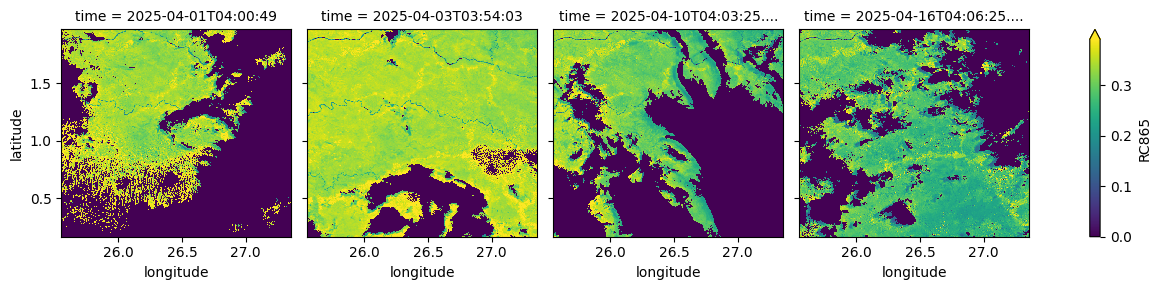

In [12]:
(ds_S3.isel(time=[0, 2, 9, 15])['RC865']*0.0001).plot(robust=True, col="time", col_wrap=4)

#### Visualise Sentinel-3 Land `IWV_L` band
The cell below visualizes the column-integrated water vapour content above each pixel. This parameter represents the total amount of water vapour in the atmosphere, expressed in kg/m².

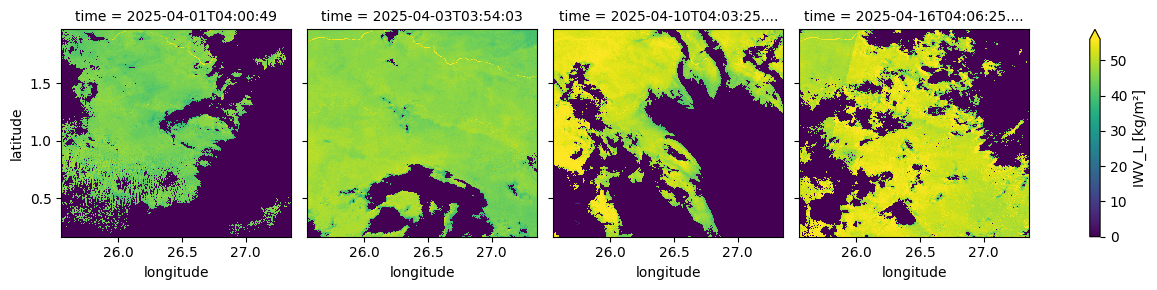

In [13]:
(ds_S3.isel(time=[0, 2, 9, 15])['IWV_L']).plot(robust=True, col="time", col_wrap=4)

#### Visualise Sentinel-3 Land `LQSF` band
The cell below visualizes the per-pixel quality and classification information, which flags conditions such as land, water, cloud, or snow. This layer is used to mask invalid observations and ensure reliable analysis.

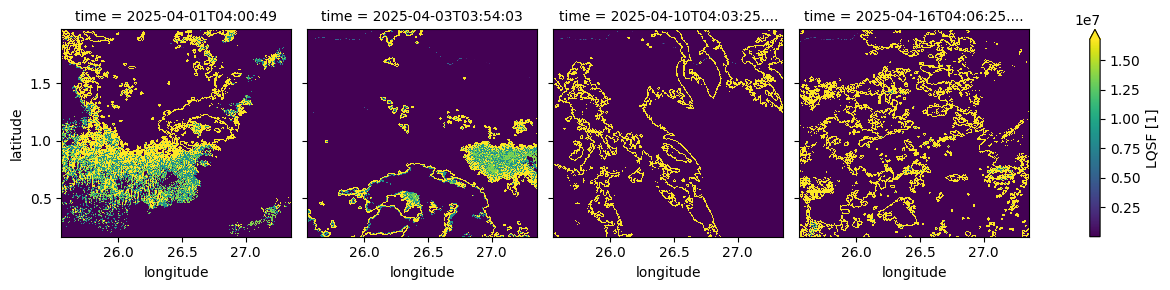

In [14]:
(ds_S3.isel(time=[0, 2, 9, 15])['LQSF']).plot(robust=True, col="time", col_wrap=4)

#### Visualise Sentinel-3 Land `dataMask` band
The cell below visualizes the binary data mask, which indicates valid versus invalid observations. Values of 0 represent invalid data, while 1 represents valid observations.

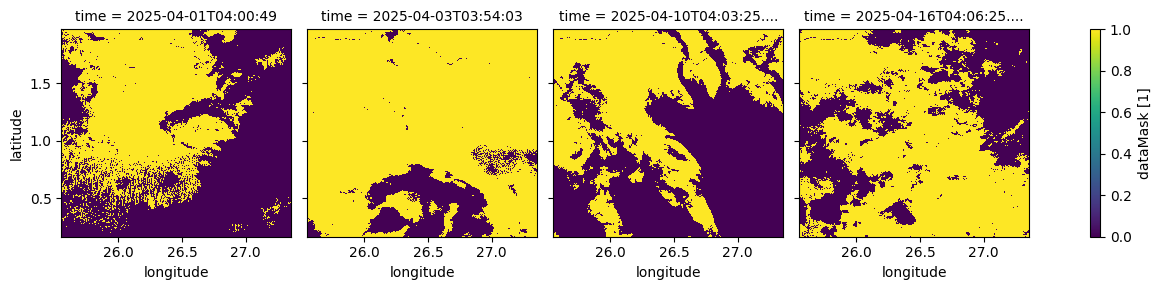

In [15]:
(ds_S3.isel(time=[0, 2, 9, 15])['dataMask']).plot(robust=True, col="time", col_wrap=4)

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

<b> Compatible datacube version </b>

In [16]:
print(datacube.__version__)

1.8.20


**Last Tested:**

In [17]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-09-09'